In [38]:
import re
import requests
from bs4 import BeautifulSoup

img_name = []
def getImage(keyword, no):
    url="https://search.naver.com/search.naver?where=image&sm=tab_jum&query="+keyword
    html = requests.get(url)
    bs_html = BeautifulSoup(html.content, 'html.parser')
    photowall = bs_html.find('div',{"class":"photowall"})
    img_list = photowall.find_all("img",{"class":"_img"})
      
    for i in range(no):
        img_link = re.findall('data-source="(.+?)"',str(img_list[i]))[0]
        img_con = requests.get(img_link).content
        file = open("dir_for_crawl/"+'sample'+str(i+1)+".jpg","wb")
        img_name.append('sample'+str(i+1))
        file.write(img_con)
        file.close()
        #print(img_link)

getImage('자동차 번호판',5)

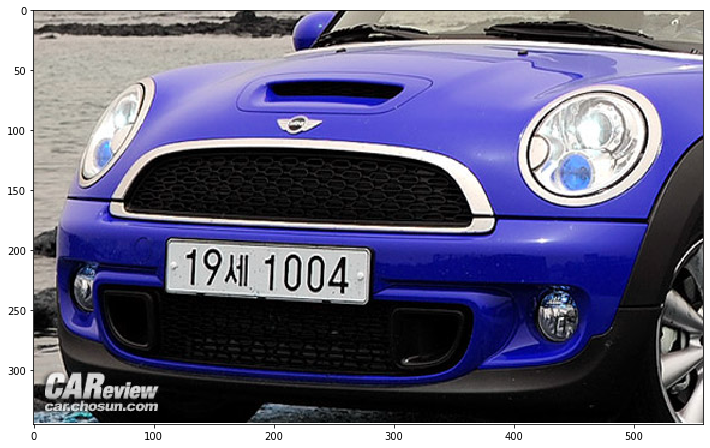

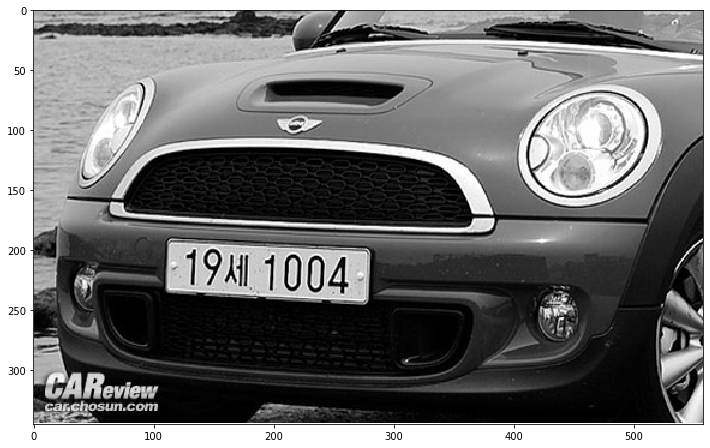

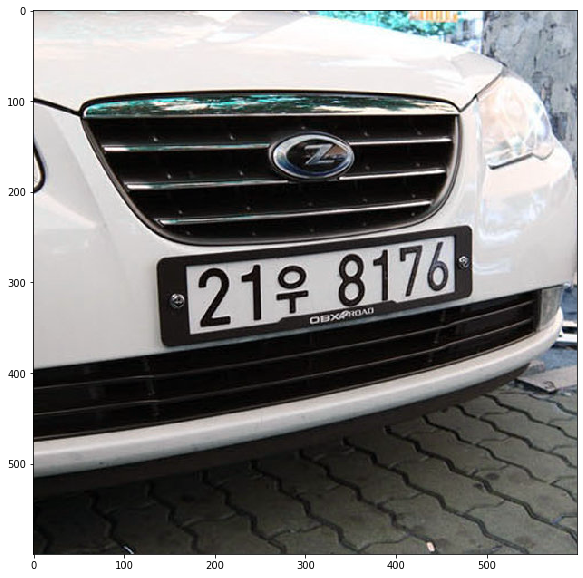

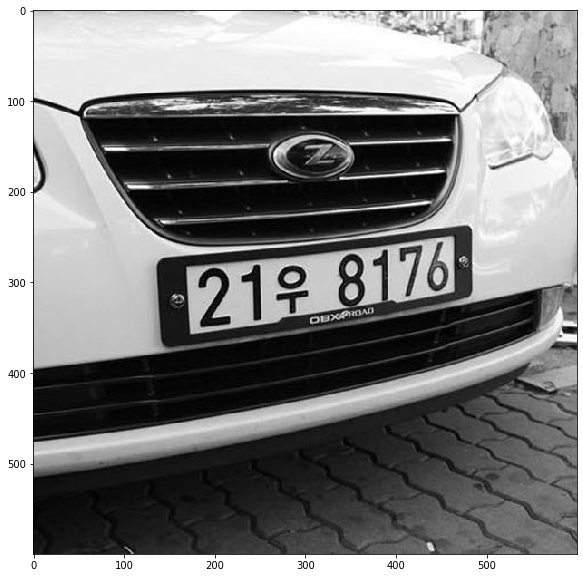

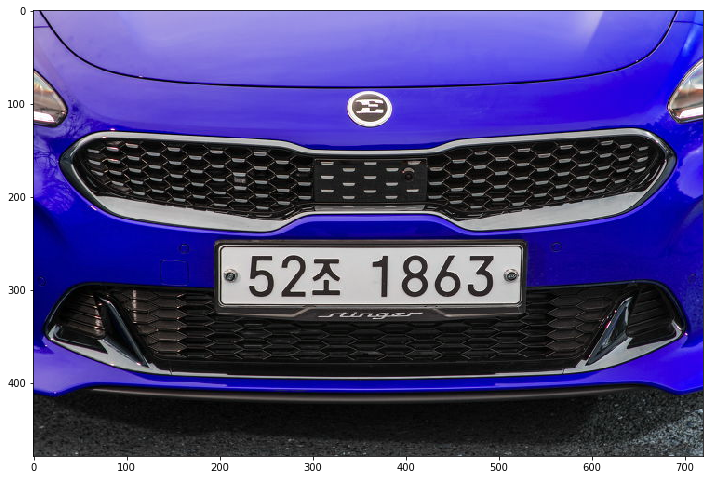

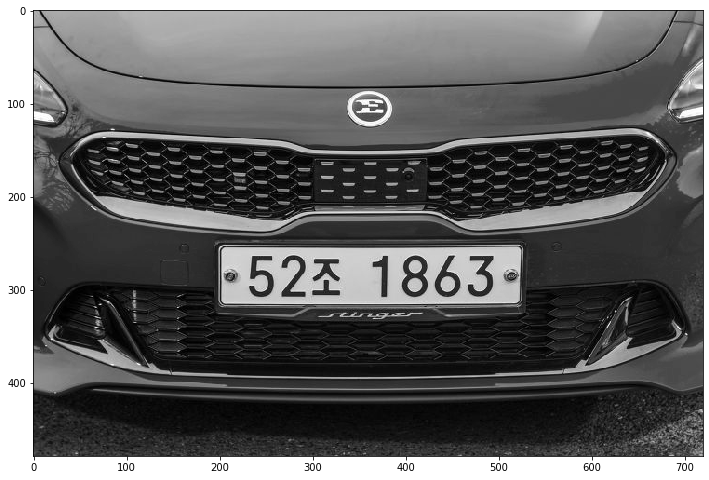

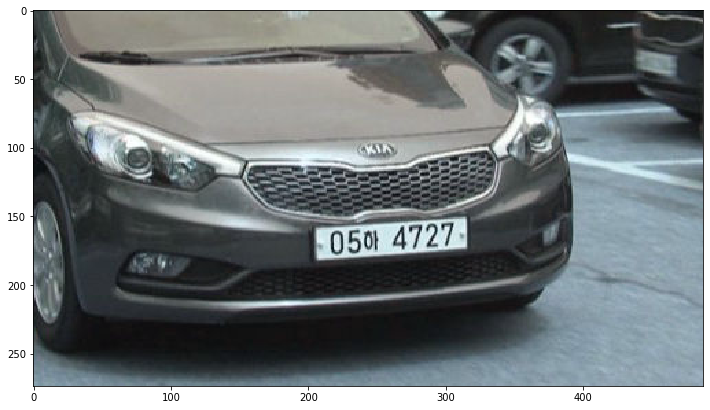

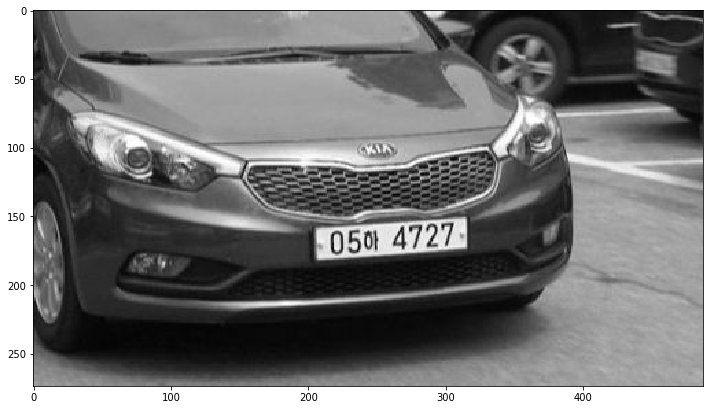

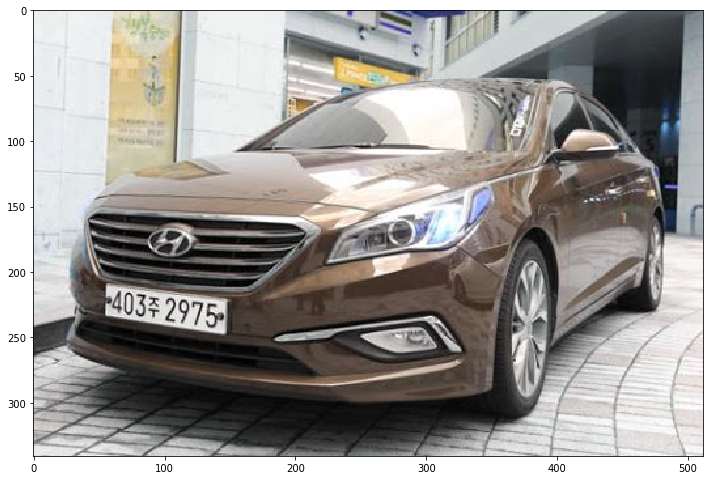

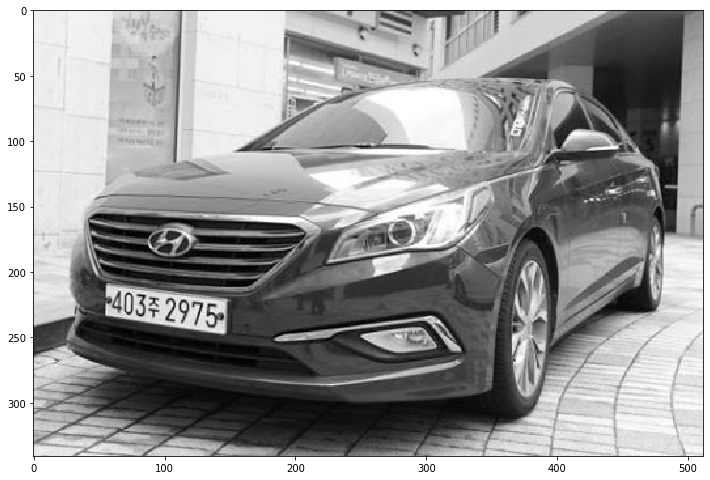

In [62]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytesseract

gray = []
height = []
width = []
channel = []
for i, name in enumerate(img_name):
    img_ori = cv2.imread("dir_for_crawl/"+name+".jpg")
    height.append(img_ori.shape[0])
    width.append(img_ori.shape[1])
    channel.append(img_ori.shape[2])
    
    plt.figure(figsize=(12,10))
    plt.imshow(img_ori, cmap='gray')
    
    gray.append(cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY))
    
    plt.figure(figsize=(12,10))
    plt.imshow(gray[i], cmap='gray')

In [51]:
#Maximize Contrast(Optional)


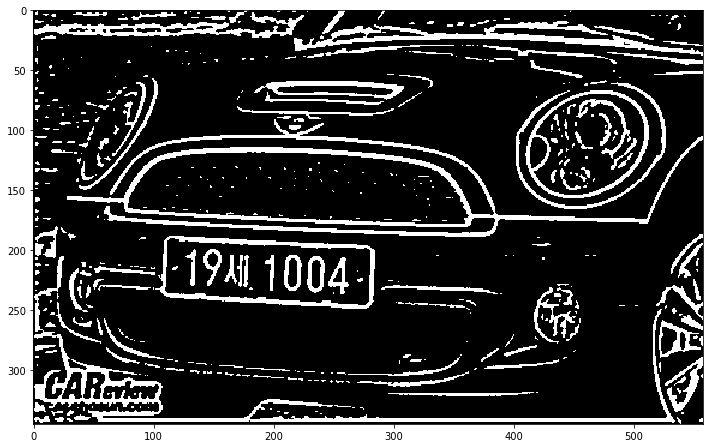

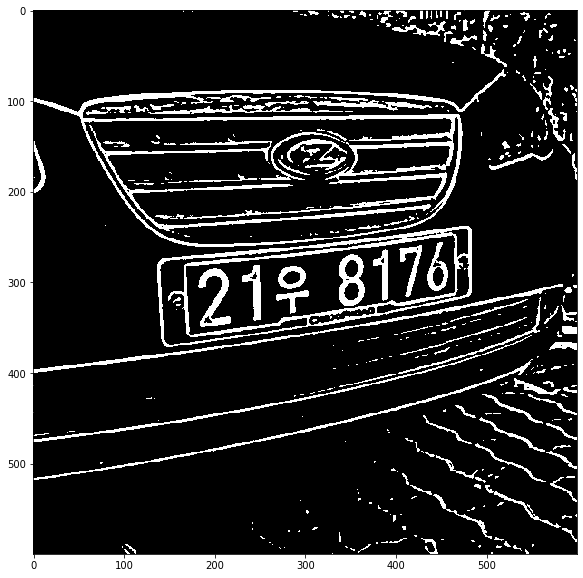

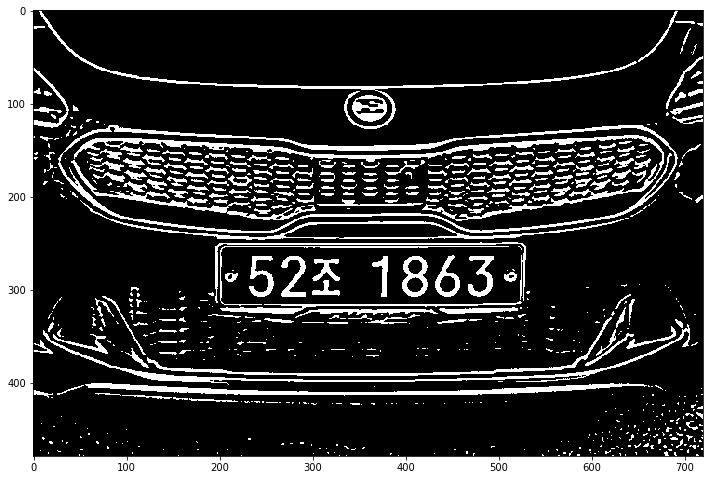

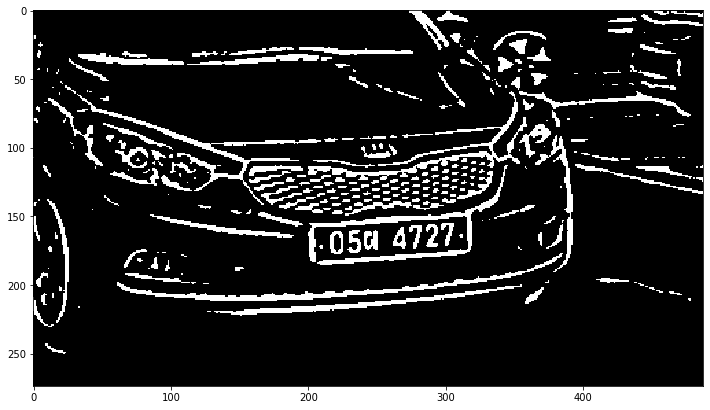

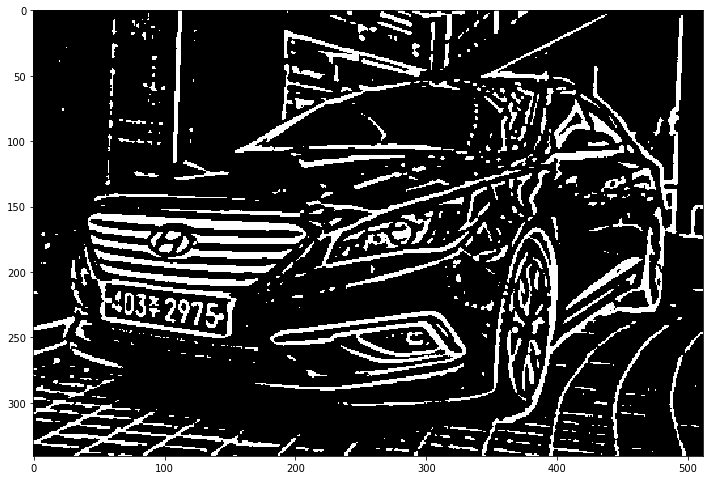

In [63]:
img_thresh = []
for i, gray in enumerate(gray):
    img_blurred = cv2.GaussianBlur(gray, ksize=(5,5), sigmaX=0)

    img_thresh.append(cv2.adaptiveThreshold(
        img_blurred,
        maxValue = 255.0,
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType=cv2.THRESH_BINARY_INV,
        blockSize=13,
        C=9
    ))

    plt.figure(figsize=(12,10))
    plt.imshow(img_thresh[i], cmap='gray')
 

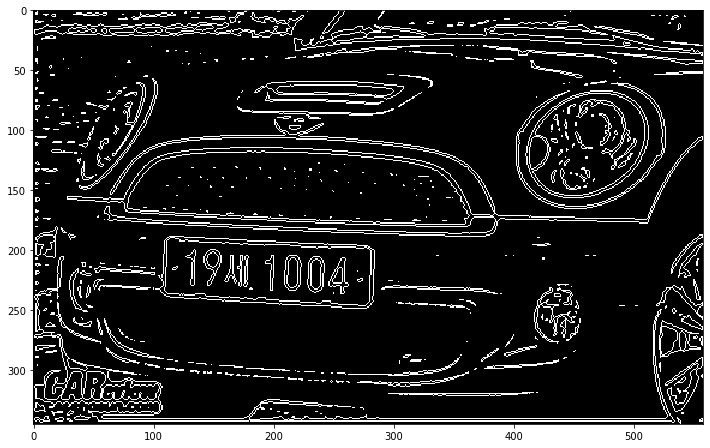

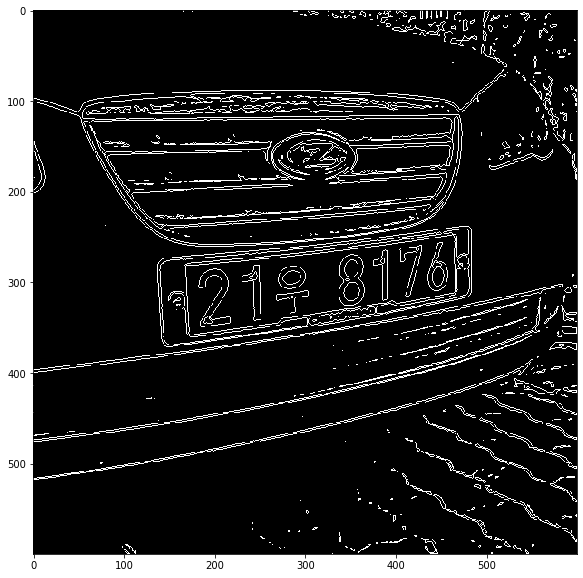

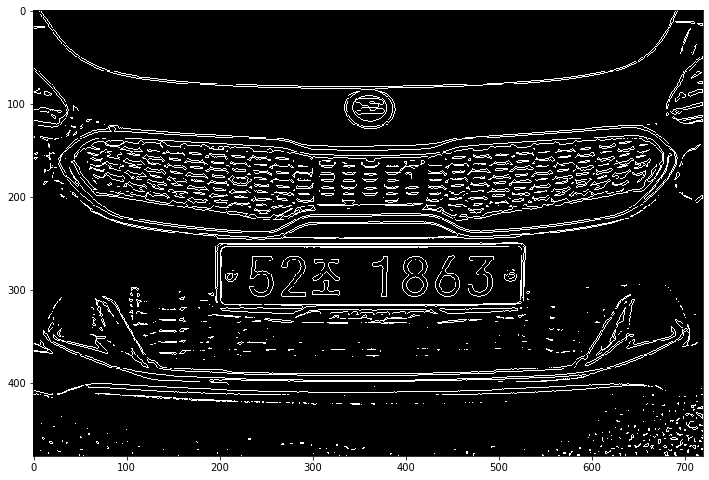

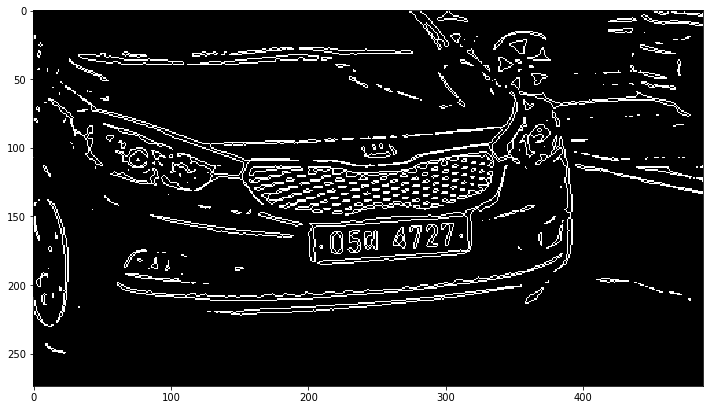

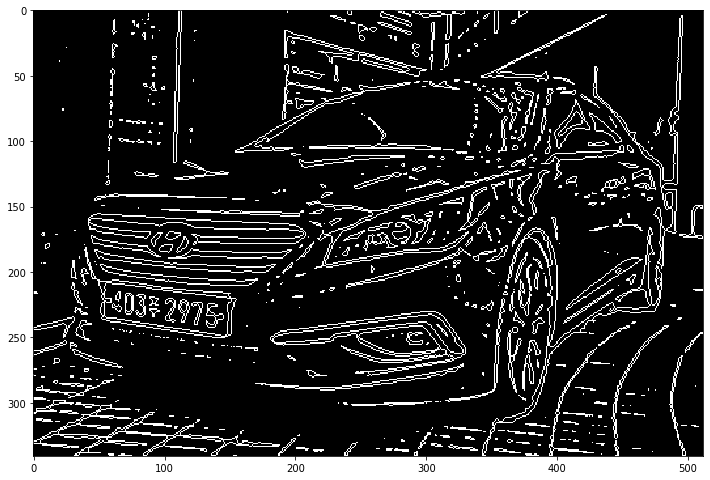

In [64]:
temp_result = []
contours = []
for i, i_thresh in enumerate(img_thresh):
    s_contours,_ = cv2.findContours(
        i_thresh, 
        mode=cv2.RETR_LIST, 
        method=cv2.CHAIN_APPROX_SIMPLE
    )  
    
    contours.append(s_contours)

    temp_result.append(np.zeros((height[i], width[i], channel[i]), dtype=np.uint8))

    cv2.drawContours(temp_result[i], contours=s_contours, contourIdx=-1, color=(255, 255, 255))

    plt.figure(figsize=(12, 10))
    plt.imshow(temp_result[i])

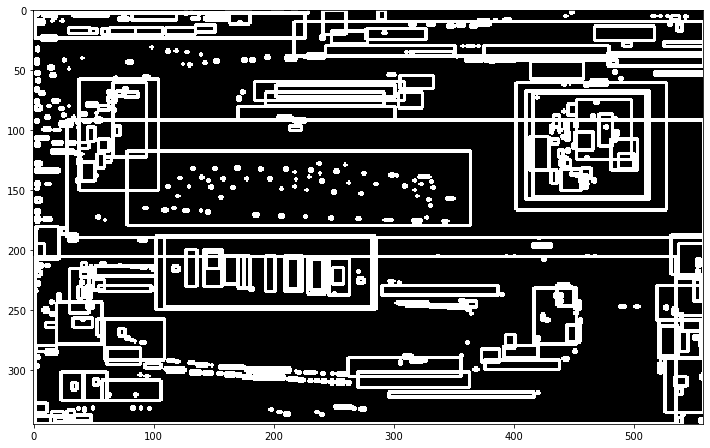

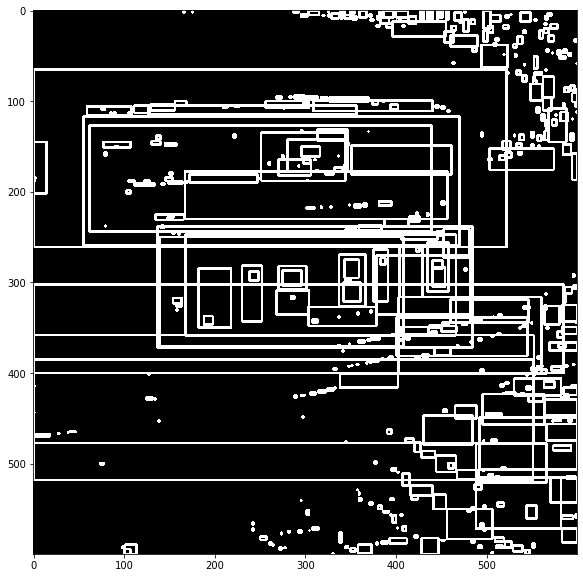

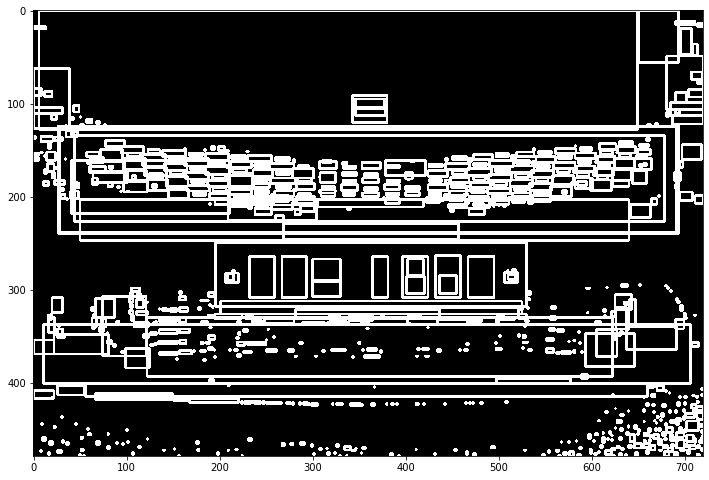

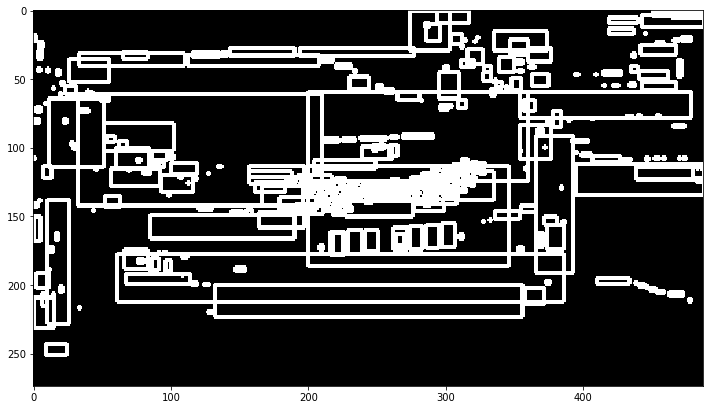

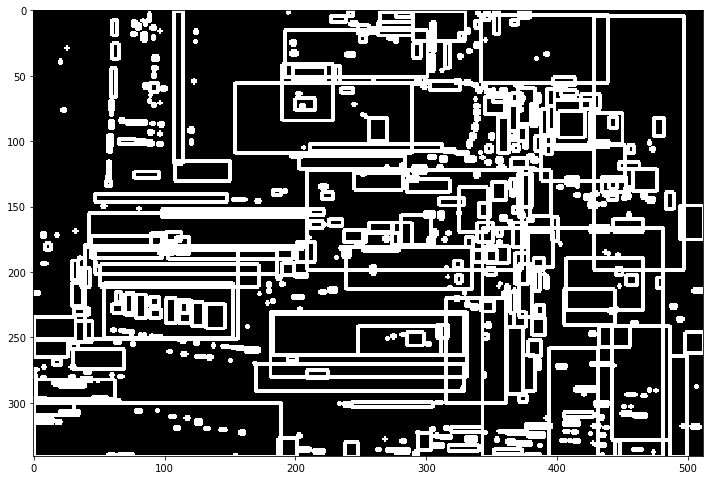

In [68]:

contours_dict = [[0] for _ in range((len(contours)))]
for i in range(len(contours)):
    temp_result = np.zeros((height[i], width[i], channel[i]), dtype=np.uint8)
    for contour in contours[i]:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(temp_result, pt1=(x,y), pt2=(x+w,y+h), color=(255,255,255), thickness=2)

        #insert to dict
        contours_dict[i].append({
            'contour': contour,
            'x' : x,
            'y' : y,
            'w' : w,
            'h' : h,
            'cx' : x+(w/2),
            'cy' : y+(h/2)
        })
    #0으로 초기화해준 것 pop
    contours_dict[i].pop(0)
    plt.figure(figsize=(12,10))
    plt.imshow(temp_result, cmap='gray')

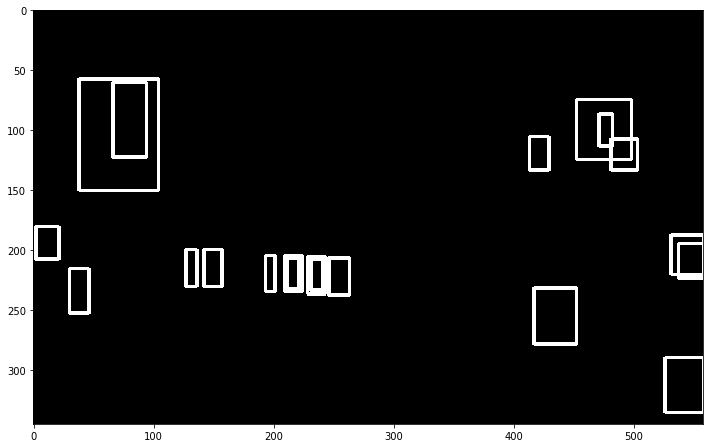

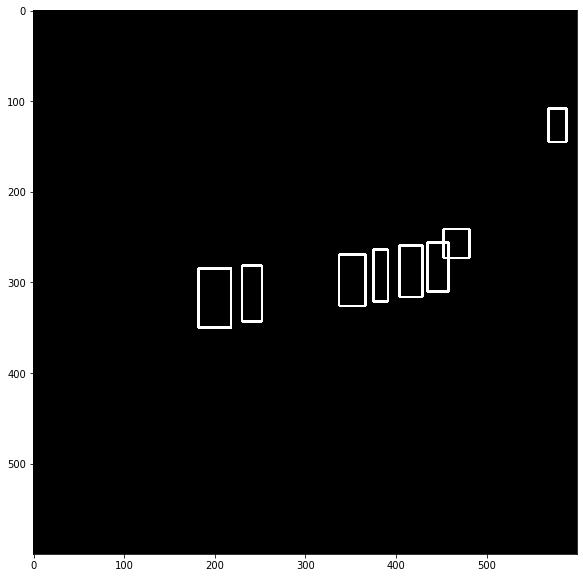

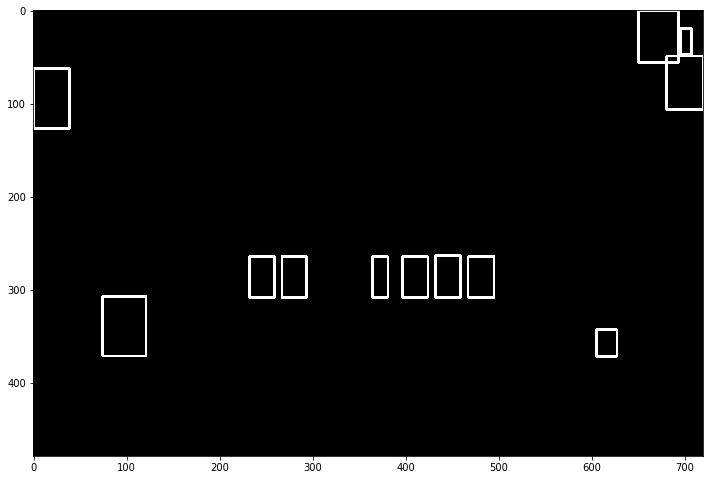

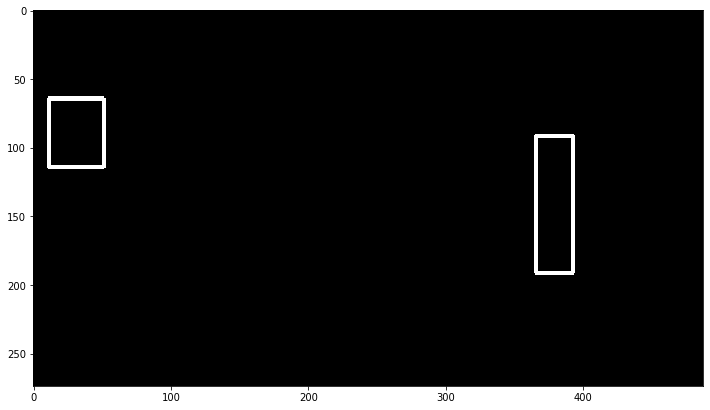

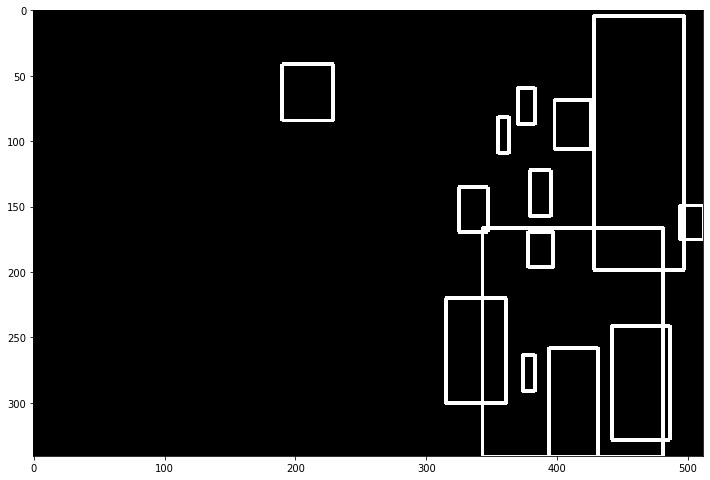

In [69]:
MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT = 2, 25
MIN_RATIO, MAX_RATIO = 0.25, 1.0
possible_contours = [[0] for _ in range((len(contours_dict)))]
for i in range(len(contours_dict)):
    cnt = 0
    for d in contours_dict[i]:
        area = d['w'] * d['h']
        ratio = d['w'] / d['h']

        if area > MIN_AREA \
        and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            d['idx'] = cnt
            cnt += 1
            possible_contours[i].append(d)

    #0으로 초기화해준 것 pop
    possible_contours[i].pop(0)
    
    #visualize possible contours
    temp_result = np.zeros((height[i], width[i], channel[i]), dtype=np.uint8)
    
    for d in possible_contours[i]:
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'],d['y']+d['h'])\
                                       , color = (255,255,255),thickness=2)
    

    plt.figure(figsize=(12, 10))
    plt.imshow(temp_result, cmap='gray')

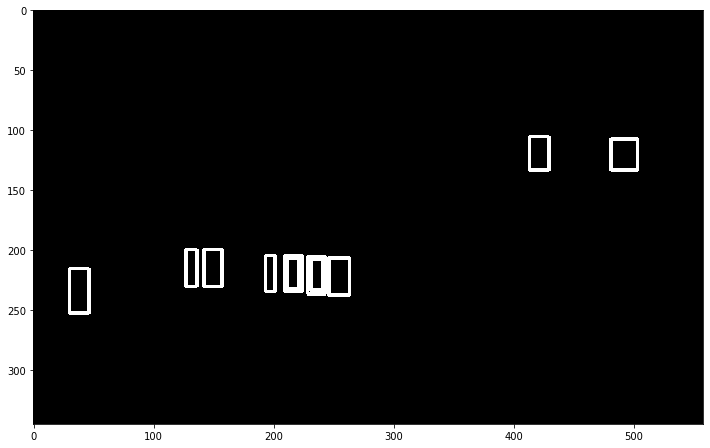

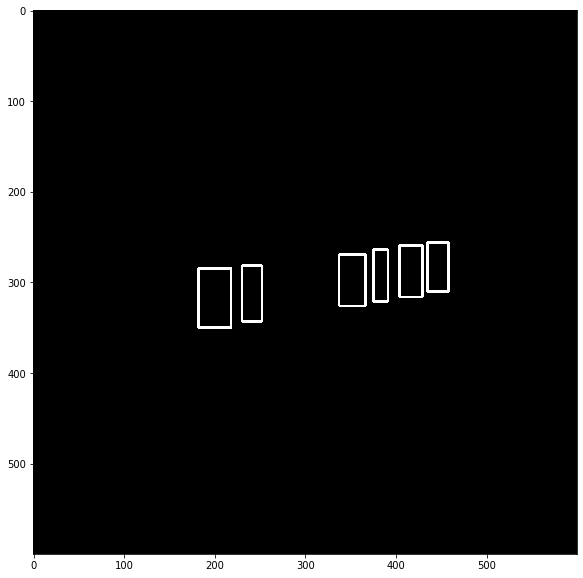

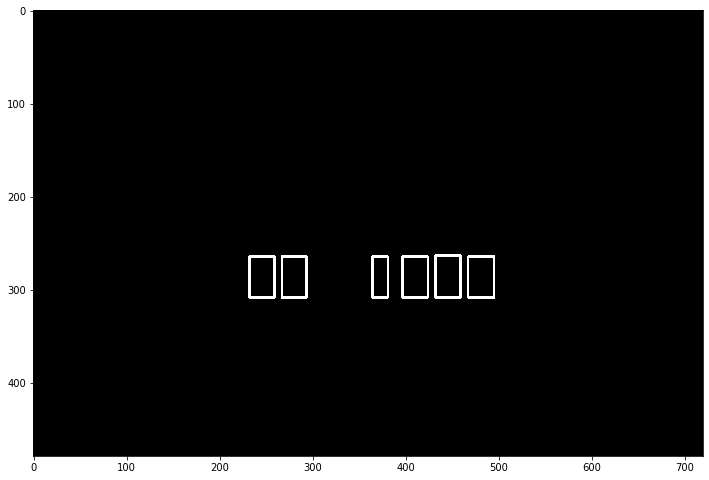

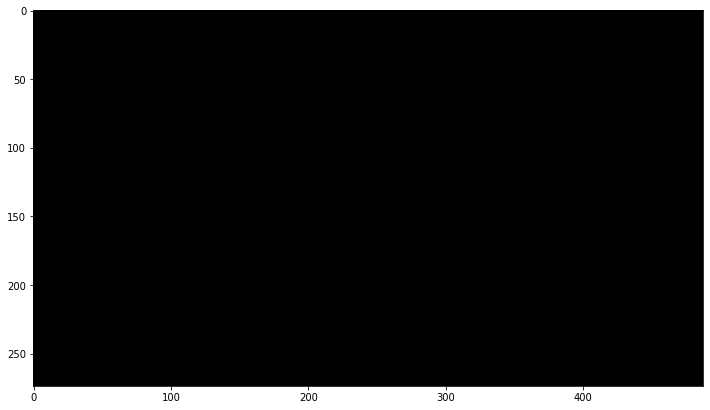

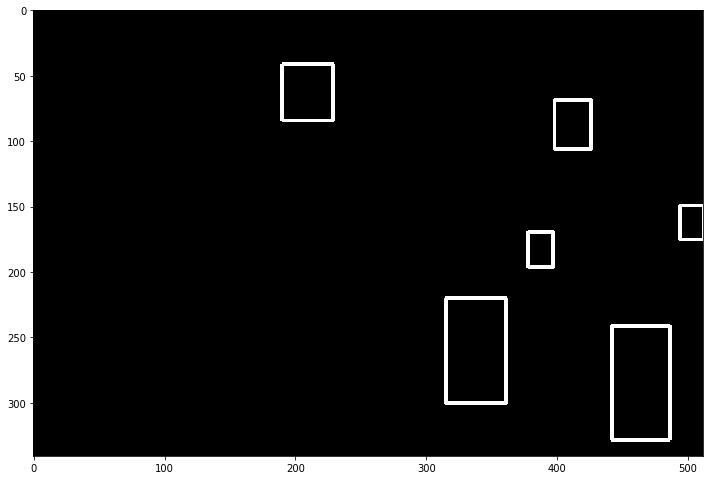

In [70]:
MAX_DIAG_MULTIPLAYER = 5
MAX_ANGLE_DIFF =12.0
MAX_AREA_DIFF = 0.4
MAX_WIDTH_DIFF = 0.8
MAX_HEIGHT_DIFF = 0.2
MIN_N_MATCHED = 2

def find_chars(contour_list):
    matched_result_idx = []
    
    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue
            
            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])
            
            #대각선의 길이
            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d2['h'] ** 2)
            
            #한 중심점에서 다른 중심점까지의 거리
            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
                
            #면적 비율, w 비율, h 비율
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']
            
            if distance < diagonal_length1 * MAX_DIAG_MULTIPLAYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF\
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])
        matched_contours_idx.append(d1['idx'])

        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue

        matched_result_idx.append(matched_contours_idx)

        unmatched_contours_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contours_idx.append(d4['idx'])
        #possible_contours에서 unmatched_contours_idx와 같은 인덱스의 값만 추출
        unmatched_contours = np.take(possible_contours[i], unmatched_contours_idx)

        recursive_contour_list = find_chars(unmatched_contours)

        for idx in recursive_contour_list:
            matched_result_idx.append(idx)
        break

    return matched_result_idx

matched_result = [[0] for _ in range((len(possible_contours)))]
for i in range(len(possible_contours)):
    result_idx = find_chars(possible_contours[i])
    for idx_list in result_idx:
        matched_result[i].append(np.take(possible_contours[i], idx_list))
    
    #0으로 초기화해준 것 pop
    matched_result[i].pop(0)
    
    temp_result = np.zeros((height[i], width[i], channel[i]), dtype=np.uint8)

    for r in matched_result[i]:
        for d in r:
            cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']),
                         color=(255,255,255), thickness=2)

    plt.figure(figsize=(12,10))
    plt.imshow(temp_result, cmap='gray')
    

            

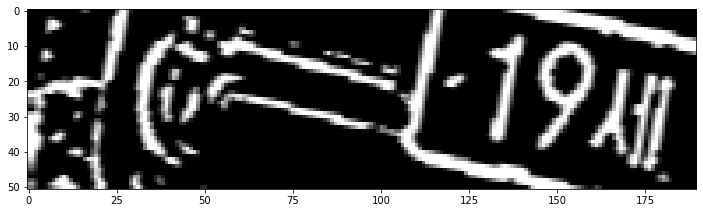

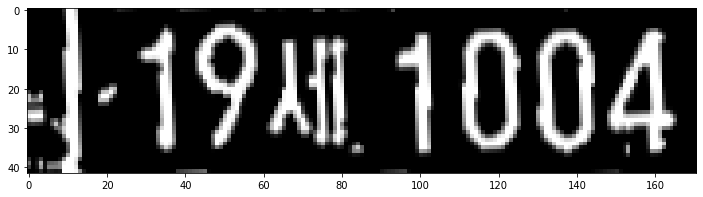

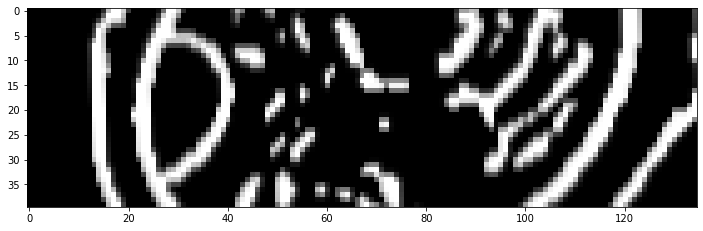

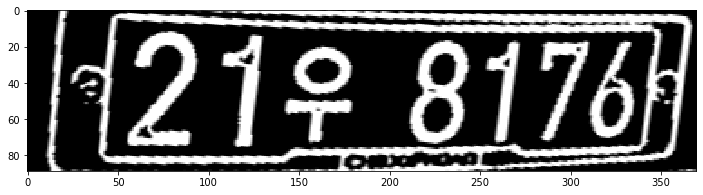

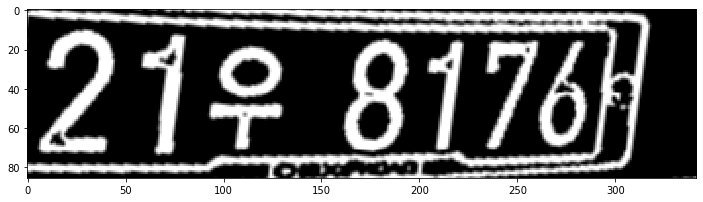

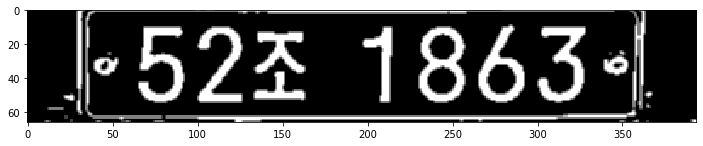

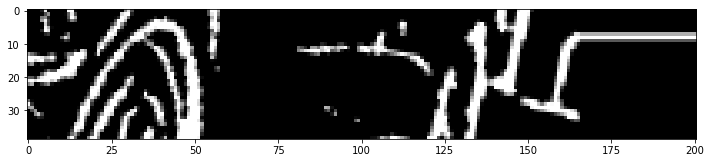

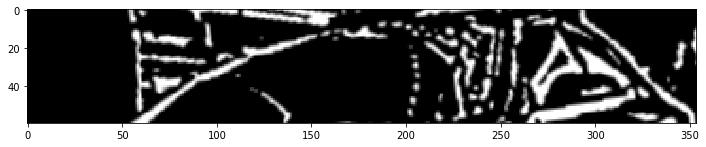

In [72]:
PLATE_WIDTH_PADDING = 1.5 # 1.3
PLATE_HEIGHT_PADDING = 1.5 # 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = [[0] for _ in range((len(matched_result)))]
plate_infos = [[0] for _ in range((len(matched_result)))]
img_cropped = [[0] for _ in range((len(matched_result)))]
img_rotated = [[0] for _ in range((len(matched_result)))]

for i in range(len(matched_result)):
    for idx, matched_chars in enumerate(matched_result[i]):
        sorted_chars = sorted(matched_chars, key=lambda x:x['cx'])
        plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
        plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2

        plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING

        sum_height = 0
        for d in sorted_chars:
            sum_height += d['h']

        plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
        
        #높이의 값
        triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
        #빗변의 길이
        triangle_hypotenus = np.linalg.norm(
            np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) -
            np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
        )
        #높이와 빗변으로 각도구함
        angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))
        rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)
        img_rotated[i] = cv2.warpAffine(img_thresh[i], M=rotation_matrix, dsize=(width[i],height[i]))
        #thresh가 안되는듯
        
        #번호판 부분만 자른다
        img_cropped[i] = cv2.getRectSubPix(
            img_rotated[i],
            patchSize = (int(plate_width), int(plate_height)),
            center = (int(plate_cx), int(plate_cy))
        )

        if img_cropped[i].shape[1] / img_cropped[i].shape[0] < MIN_PLATE_RATIO or img_cropped[i].shape[1] / img_cropped[i].shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
            continue

        plt.figure(figsize=(12,10))
        plt.imshow(img_cropped[i], cmap='gray')